In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import graphviz
import re

%matplotlib inline

airbnb seattle data is available here:  
https://www.kaggle.com/airbnb/seattle/data  
Listings : Attributes and ratings of listings  
Calendar : Availability and price of each listing and each day  
Reviews : Reviewers, review dates and comments for each listing

In [22]:
listings_df = pd.read_csv('data/listings.csv')
calendar_df = pd.read_csv('data/calendar.csv')

### Selecting columns for prediction

In [23]:
listings_df_sel = listings_df[[
     'id'
    ,'bed_type'
    ,'cancellation_policy'
    ,'neighbourhood_group_cleansed'
    ,'property_type'
    ,'reviews_per_month'
    ,'number_of_reviews'
    ,'room_type'
    ,'bedrooms'
    ,'bathrooms'
    ,'beds'
    ,'guests_included'
    ,'review_scores_rating'
    ,'amenities'
]]

In [24]:
listings_df_sel.head()

,id,bed_type,cancellation_policy,neighbourhood_group_cleansed,property_type,reviews_per_month,number_of_reviews,room_type,bedrooms,bathrooms,beds,guests_included,review_scores_rating,amenities
0,241032,Real Bed,moderate,Queen Anne,Apartment,4.07,207,Entire home/apt,1.0,1.0,1.0,2,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Real Bed,strict,Queen Anne,Apartment,1.48,43,Entire home/apt,1.0,1.0,1.0,1,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,Real Bed,strict,Queen Anne,House,1.15,20,Entire home/apt,5.0,4.5,7.0,10,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,7421966,Real Bed,flexible,Queen Anne,Apartment,NaN,0,Entire home/apt,0.0,1.0,2.0,1,NaN,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,278830,Real Bed,strict,Queen Anne,House,0.89,38,Entire home/apt,3.0,2.0,3.0,6,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


### Handling missing data

In [25]:
# check number of rows
listings_df_sel.shape[0]

3818

In [26]:
# remove listings which do not have rating
listings_df_cl = listings_df_sel.dropna(subset=['review_scores_rating']).copy()
listings_df_cl.shape[0]

3171

In [27]:
listings_df_cl.isnull().sum().sort_values(ascending=False)

bathrooms                       12
bedrooms                         6
amenities                        0
review_scores_rating             0
guests_included                  0
beds                             0
room_type                        0
number_of_reviews                0
reviews_per_month                0
property_type                    0
neighbourhood_group_cleansed     0
cancellation_policy              0
bed_type                         0
id                               0
dtype: int64

In [28]:
# handle missing value for bathrooms
listings_df_cl['bathrooms'].value_counts()

1.0    2414
2.0     304
1.5     203
2.5      97
3.0      53
3.5      50
0.5      21
4.0       6
0.0       4
4.5       3
5.0       2
8.0       2
Name: bathrooms, dtype: int64

In [29]:
# put 0 for bathrooms where value is missing
listings_df_cl['bathrooms'] = listings_df_cl['bathrooms'].fillna(value=0)

In [30]:
listings_df_cl['bedrooms'].value_counts()

1.0    2013
2.0     533
0.0     307
3.0     236
4.0      52
5.0      17
6.0       6
7.0       1
Name: bedrooms, dtype: int64

In [50]:
# put 0 for bedrooms where value is missing
listings_df_cl['bedrooms'] = listings_df_cl['bedrooms'].fillna(value=0)

In [32]:
listings_df_cl.head()

,id,bed_type,cancellation_policy,neighbourhood_group_cleansed,property_type,reviews_per_month,number_of_reviews,room_type,bedrooms,bathrooms,beds,guests_included,review_scores_rating,amenities
0,241032,Real Bed,moderate,Queen Anne,Apartment,4.07,207,Entire home/apt,1.0,1.0,1.0,2,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Real Bed,strict,Queen Anne,Apartment,1.48,43,Entire home/apt,1.0,1.0,1.0,1,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,Real Bed,strict,Queen Anne,House,1.15,20,Entire home/apt,5.0,4.5,7.0,10,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
4,278830,Real Bed,strict,Queen Anne,House,0.89,38,Entire home/apt,3.0,2.0,3.0,6,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
5,5956968,Real Bed,strict,Queen Anne,House,2.45,17,Private room,1.0,1.0,1.0,1,95.0,"{""Wireless Internet"",""Free Parking on Premises..."


### Handling categorical data

In [56]:
listings_df_cl

,id,bed_type,cancellation_policy,neighbourhood_group_cleansed,property_type,reviews_per_month,number_of_reviews,room_type,bedrooms,bathrooms,beds,guests_included,review_scores_rating,amenities
0,241032,Real Bed,moderate,Queen Anne,Apartment,4.07,207,Entire home/apt,1.0,1.0,1.0,2,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Real Bed,strict,Queen Anne,Apartment,1.48,43,Entire home/apt,1.0,1.0,1.0,1,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,Real Bed,strict,Queen Anne,House,1.15,20,Entire home/apt,5.0,4.5,7.0,10,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
4,278830,Real Bed,strict,Queen Anne,House,0.89,38,Entire home/apt,3.0,2.0,3.0,6,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
5,5956968,Real Bed,strict,Queen Anne,House,2.45,17,Private room,1.0,1.0,1.0,1,95.0,"{""Wireless Internet"",""Free Parking on Premises..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,262764,Real Bed,strict,Other neighborhoods,House,1.56,5,Entire home/apt,2.0,1.0,3.0,4,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
3811,8578490,Real Bed,moderate,Other neighborhoods,Apartment,0.63,2,Entire home/apt,1.0,1.0,1.0,1,100.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3812,3383329,Real Bed,moderate,Other neighborhoods,Apartment,4.01,73,Entire home/apt,1.0,1.0,2.0,2,96.0,"{Internet,""Wireless Internet"",Kitchen,""Free Pa..."
3813,8101950,Real Bed,strict,Other neighborhoods,House,0.30,1,Entire home/apt,3.0,2.0,3.0,1,80.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."


In [57]:
listings_df_dum = listings_df_cl.copy()

# get dummy columns for categorical columns
for col in ['bed_type','cancellation_policy','neighbourhood_group_cleansed','property_type','room_type']:
    listings_df_dum = pd.concat([listings_df_dum.drop(col,axis=1), pd.get_dummies(listings_df_dum[col],col)],axis=1)

# get unique amenities
amenities = []
for line in listings_df_cl['amenities']:
    amenities.extend(re.sub('["{}]','',line).split(','))
unique_amenities = set(amenities)

# add dummy columns for amenities
for amenity in unique_amenities:
    listings_df_dum['amenities_' + amenity] = \
        listings_df_cl['amenities'].apply(lambda line:1 if amenity in re.sub('["{}]','',line).split(',') else 0)

listings_df_dum = listings_df_dum.drop('amenities',axis=1)

In [59]:
listings_df_dum.head()

,id,reviews_per_month,number_of_reviews,bedrooms,bathrooms,beds,guests_included,review_scores_rating,bed_type_Airbed,bed_type_Couch,...,amenities_Heating,amenities_Cable TV,amenities_Buzzer/Wireless Intercom,amenities_First Aid Kit,amenities_Gym,amenities_Carbon Monoxide Detector,amenities_Dryer,amenities_Pets Allowed,amenities_Family/Kid Friendly,amenities_Pool
0,241032,4.07,207,1.0,1.0,1.0,2,95.0,0,0,...,1,1,0,0,0,0,1,0,1,0
1,953595,1.48,43,1.0,1.0,1.0,1,96.0,0,0,...,1,0,1,1,0,1,1,0,1,0
2,3308979,1.15,20,5.0,4.5,7.0,10,97.0,0,0,...,1,1,0,0,0,1,1,1,1,0
4,278830,0.89,38,3.0,2.0,3.0,6,92.0,0,0,...,1,1,0,1,0,1,0,0,1,0
5,5956968,2.45,17,1.0,1.0,1.0,1,95.0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Formatting data

In [60]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [61]:
# format values of calendar_df
calendar_df_cl = pd.DataFrame()
calendar_df_cl['listing_id'] = calendar_df['listing_id']
calendar_df_cl['date'] = pd.to_datetime(calendar_df['date'])
calendar_df_cl['available'] = calendar_df['available'].apply(lambda s:True if s=='t' else False)
calendar_df_cl['price'] = calendar_df['price'].apply(lambda s:np.nan if s is np.nan else float(s.replace('$','').replace(',','')))

In [62]:
calendar_df_cl.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [63]:
calendar_df_agg = calendar_df_cl[calendar_df_cl['available']==True]\
    .groupby('listing_id')['price'].mean().to_frame()\
    .reset_index()

In [64]:
calendar_df_agg.head()

,listing_id,price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000


### Merge listings and calendar data

In [123]:
merged_df = pd.merge(listings_df_dum,calendar_df_agg
         ,how='inner'
         ,left_on='id'
         ,right_on='listing_id')
merged_df.to_csv('data/merged.csv')
merged_df.head()

,id,reviews_per_month,number_of_reviews,bedrooms,bathrooms,beds,guests_included,review_scores_rating,bed_type_Airbed,bed_type_Couch,...,amenities_Buzzer/Wireless Intercom,amenities_First Aid Kit,amenities_Gym,amenities_Carbon Monoxide Detector,amenities_Dryer,amenities_Pets Allowed,amenities_Family/Kid Friendly,amenities_Pool,listing_id,price
0,241032,4.07,207,1.0,1.0,1.0,2,95.0,0,0,...,0,0,0,0,1,0,1,0,241032,85.000000
1,953595,1.48,43,1.0,1.0,1.0,1,96.0,0,0,...,1,1,0,1,1,0,1,0,953595,170.931271
2,3308979,1.15,20,5.0,4.5,7.0,10,97.0,0,0,...,0,0,0,1,1,1,1,0,3308979,1301.818182
3,278830,0.89,38,3.0,2.0,3.0,6,92.0,0,0,...,0,1,0,1,0,0,1,0,278830,462.739726
4,5956968,2.45,17,1.0,1.0,1.0,1,95.0,0,0,...,0,0,0,0,0,0,0,0,5956968,125.629139


# How should I set price?

In [125]:
X = merged_df.drop(['review_scores_rating','reviews_per_month','id','listing_id','price'],axis=1)
y = merged_df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [126]:
model = DecisionTreeRegressor(max_depth=5,min_samples_leaf=6)
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
r2_score(y_test,y_test_pred)

0.5611397082945133

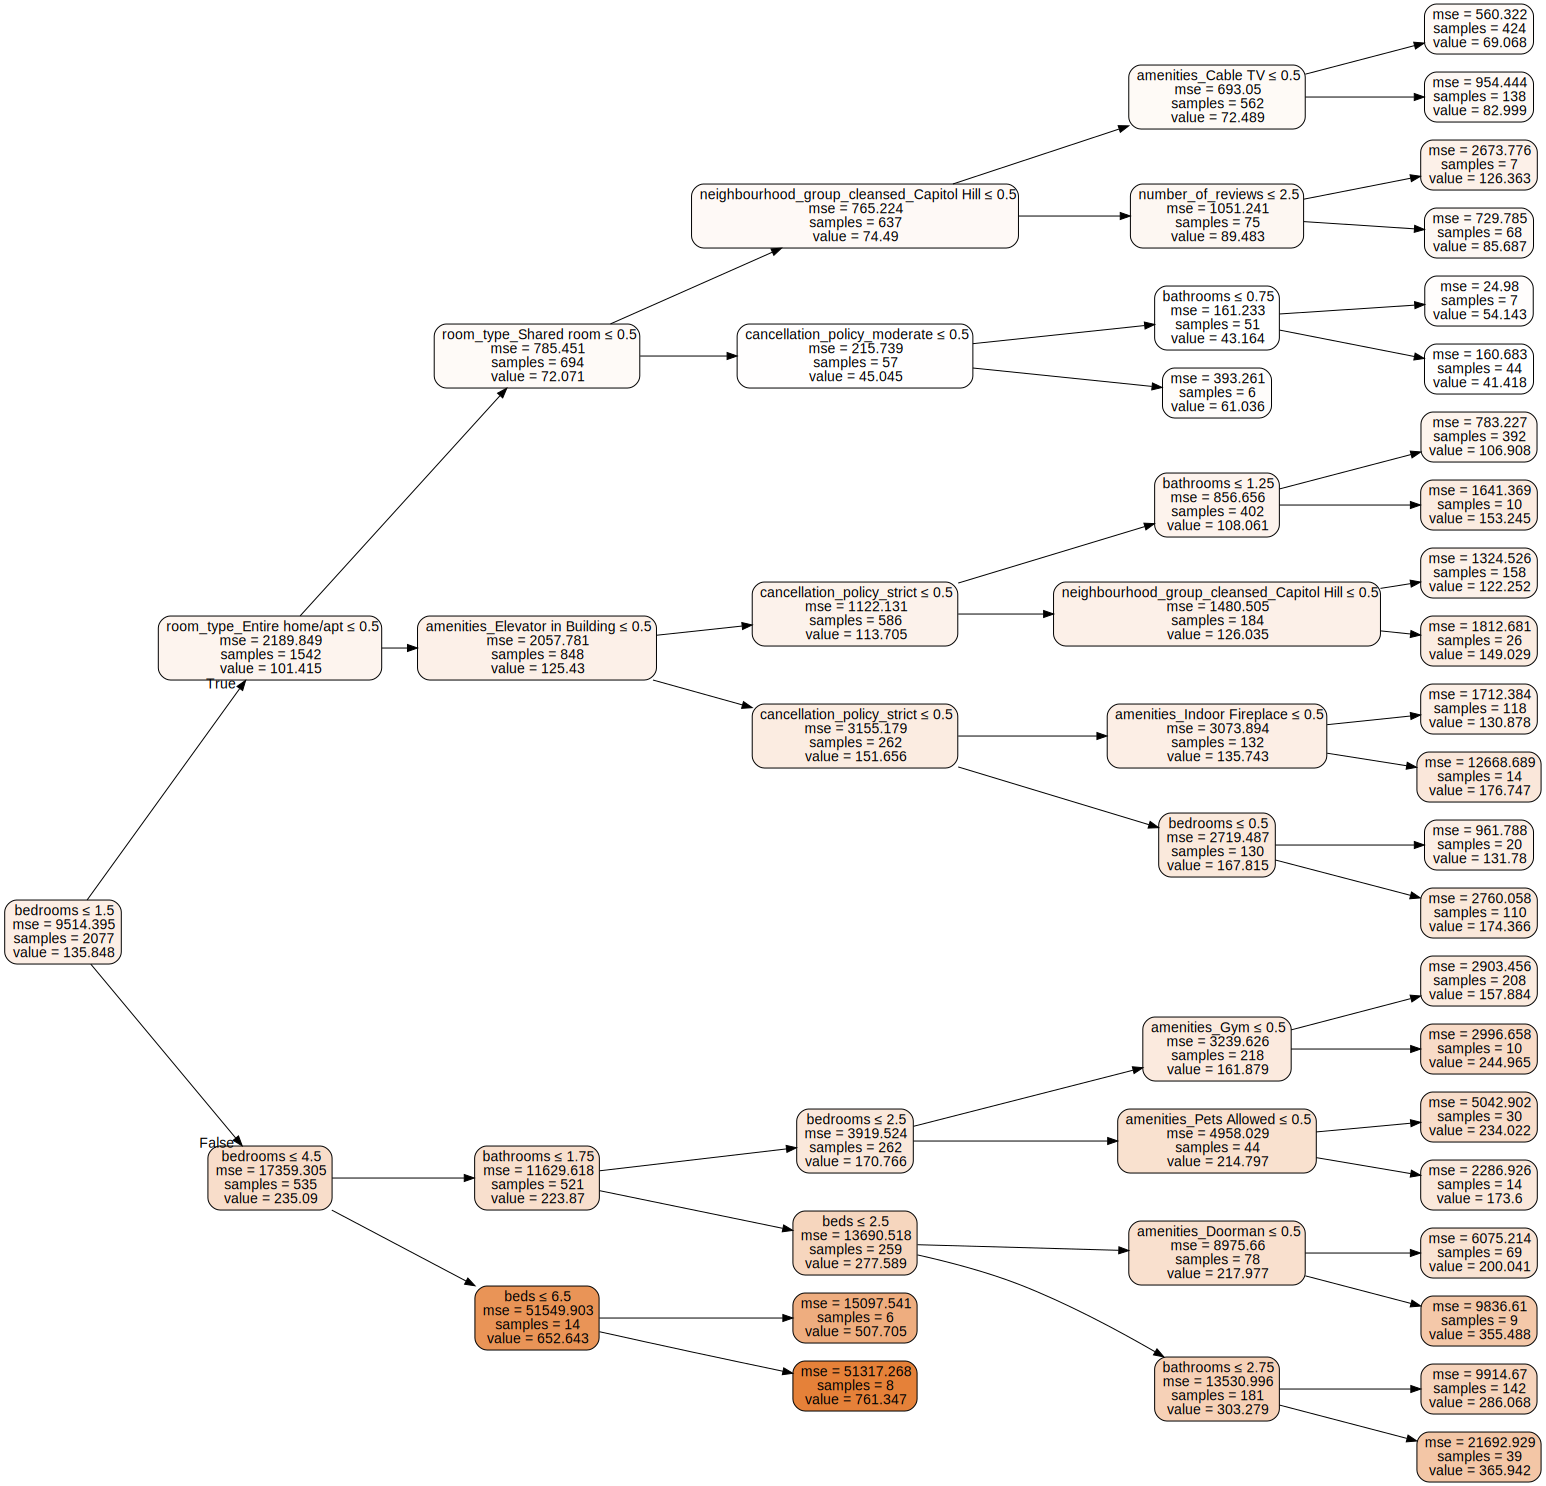

In [127]:
# output a png file
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=X.columns,  
                       
                     filled=True, rounded=True,  
                     special_characters=True,
                               rotate=True)  

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('result/pricing_tree',cleanup=True)
graph

# How I can get good ratings?

In [88]:
merged_df.head()

,id,reviews_per_month,number_of_reviews,bedrooms,bathrooms,beds,guests_included,review_scores_rating,bed_type_Airbed,bed_type_Couch,...,amenities_Buzzer/Wireless Intercom,amenities_First Aid Kit,amenities_Gym,amenities_Carbon Monoxide Detector,amenities_Dryer,amenities_Pets Allowed,amenities_Family/Kid Friendly,amenities_Pool,listing_id,price
0,241032,4.07,207,1.0,1.0,1.0,2,95.0,0,0,...,0,0,0,0,1,0,1,0,241032,85.000000
1,953595,1.48,43,1.0,1.0,1.0,1,96.0,0,0,...,1,1,0,1,1,0,1,0,953595,170.931271
2,3308979,1.15,20,5.0,4.5,7.0,10,97.0,0,0,...,0,0,0,1,1,1,1,0,3308979,1301.818182
3,278830,0.89,38,3.0,2.0,3.0,6,92.0,0,0,...,0,1,0,1,0,0,1,0,278830,462.739726
4,5956968,2.45,17,1.0,1.0,1.0,1,95.0,0,0,...,0,0,0,0,0,0,0,0,5956968,125.629139


In [128]:
X_columns = []
X_columns.extend(filter(lambda column:'amenities' in column,merged_df.columns))
X_columns.extend(filter(lambda column:'neighbourhood_group' in column,merged_df.columns))
#X_columns.extend(filter(lambda column:'room_type' in column,merged_df.columns))
#X_columns.extend(filter(lambda column:'property_type' in column,merged_df.columns))
#X_columns.extend(filter(lambda column:'bed_type' in column,merged_df.columns))
#X_columns.extend(['cancellation_policy_moderate'])

X = merged_df[X_columns]
y = merged_df['review_scores_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

model = DecisionTreeRegressor(max_depth=4,min_samples_leaf=6)
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
r2_score(y_test,y_test_pred)

0.09317420844627355

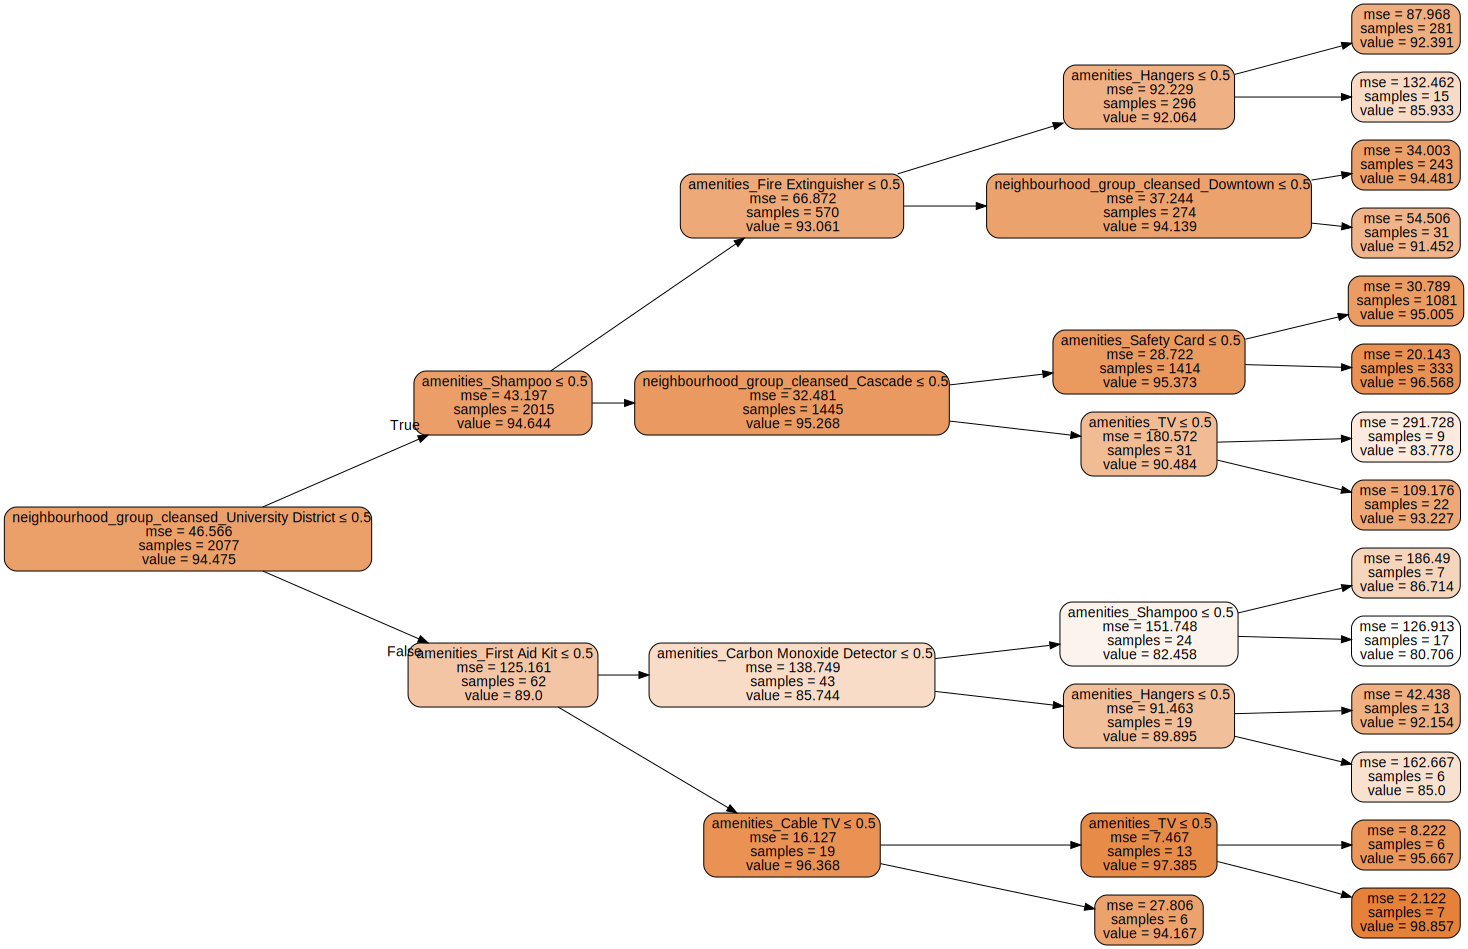

In [130]:
# output a png file
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=X.columns,  
                       
                     filled=True, rounded=True,  
                     special_characters=True,
                               rotate=True)  

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('result/rating_tree',cleanup=True)
graph